## Imports

In [3]:
import os, sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

## LSUV

In [3]:
#export
from exp.nb_07 import *

In [4]:
x_train,y_train,x_valid,y_valid = get_data()

x_train,x_valid = normalize_to(x_train,x_valid)
train_ds,valid_ds = Dataset(x_train, y_train),Dataset(x_valid, y_valid)

nh,bs = 50,128
c = y_train.max().item()+1
loss_func = F.cross_entropy

data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

In [5]:
mnist_view = view_tfm(1,28,28)
cbfs = [Recorder,
        partial(AvgStatsCallback,accuracy),
        CudaCallback,
        partial(BatchTransformXCallback, mnist_view)]

In [6]:
nfs = [8,16,32,64,64]
class ConvLayer(nn.Module):
    def __init__(self, ni, nf, ks=3, stride=2, sub=0., **kwargs):
        super().__init__()
        self.conv = nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=True)
        self.relu = GeneralRelu(sub=sub, **kwargs)
    
    def forward(self, x): return self.relu(self.conv(x))
    
    @property
    def bias(self): return -self.relu.sub
    @bias.setter
    def bias(self,v): self.relu.sub = -v
    @property
    def weight(self): return self.conv.weight

In [7]:
learn,run = get_learn_run(nfs, data, 0.6, ConvLayer, cbs=cbfs)

In [39]:
Learner.children = lambda x: list(x.model.children())

In [9]:
learn.model

Sequential(
  (0): ConvLayer(
    (conv): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (relu): GeneralRelu()
  )
  (1): ConvLayer(
    (conv): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (relu): GeneralRelu()
  )
  (2): ConvLayer(
    (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (relu): GeneralRelu()
  )
  (3): ConvLayer(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (relu): GeneralRelu()
  )
  (4): ConvLayer(
    (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (relu): GeneralRelu()
  )
  (5): AdaptiveAvgPool2d(output_size=1)
  (6): Lambda()
  (7): Linear(in_features=64, out_features=10, bias=True)
)

In [40]:
run.fit(2, learn)

train: [0.66511171875, tensor(0.7822, device='cuda:0')]
valid: [0.12899239501953125, tensor(0.9629, device='cuda:0')]
train: [0.121854140625, tensor(0.9643, device='cuda:0')]
valid: [0.08859423828125, tensor(0.9748, device='cuda:0')]


In [52]:
# With lSUV
learn,run = get_learn_run(nfs, data, 0.6, ConvLayer, cbs=cbfs)

In [53]:
#export
def find_modules(m, cond):
    if cond(m): return [m]
    return sum([find_modules(o,cond) for o in m.children()], [])

def is_lin_layer(l):
    lin_layers = (nn.Conv1d, nn.Conv2d, nn.Conv3d, nn.Linear, nn.ReLU)
    return isinstance(l, lin_layers)
mods = find_modules(learn.model, lambda o: isinstance(o,ConvLayer))

In [54]:
#export
def get_batch(dl, run):
    run.xb,run.yb = next(iter(dl))
    for cb in run.cbs: cb.set_runner(run)
    run('begin_batch')
    return run.xb,run.yb

xb,yb = get_batch(data.train_dl, run)

In [55]:
def append_stat(hook, mod, inp, outp):
    d = outp.data
    hook.mean,hook.std = d.mean().item(),d.std().item()

mdl = learn.model.cuda()

with Hooks(mods, append_stat) as hooks:
    mdl(xb)

for hook in hooks: print(hook.mean,hook.std)

0.4082559049129486 0.9148072004318237
0.42271336913108826 0.9619936347007751
0.42430564761161804 0.8008230924606323
0.45385774970054626 0.6626458764076233
0.3664337396621704 0.5109293460845947


In [56]:
#export
def lsuv_module(m, xb):
    h = Hook(m, append_stat)
    mdl(xb)

    m.bias -= h.mean
    m.weight.data /= h.std

    h.remove()
    return h.mean,h.std

In [57]:
for m in mods:
    print(lsuv_module(m, xb))

(0.4082559049129486, 0.9148072004318237)
(0.4387704133987427, 0.9219021797180176)
(0.36798495054244995, 0.7141125202178955)
(0.5047606229782104, 0.7659966945648193)
(0.4273448586463928, 0.6212998032569885)


In [62]:
xb,yb = get_batch(data.train_dl, run)
yb

tensor([0, 2, 0, 4, 2, 5, 5, 3, 1, 0, 9, 1, 6, 2, 3, 5, 8, 3, 5, 5, 7, 4, 8, 5,
        3, 5, 6, 5, 7, 6, 3, 2, 2, 1, 5, 7, 9, 4, 4, 7, 4, 9, 1, 3, 3, 2, 2, 8,
        1, 4, 0, 9, 7, 1, 2, 0, 3, 4, 0, 8, 7, 6, 0, 9, 0, 5, 1, 4, 4, 0, 4, 4,
        3, 0, 9, 9, 3, 7, 4, 0, 1, 2, 2, 2, 8, 1, 9, 9, 4, 4, 0, 5, 9, 9, 3, 4,
        1, 3, 8, 3, 1, 3, 9, 8, 8, 4, 3, 6, 2, 1, 8, 1, 6, 0, 5, 0, 2, 2, 3, 4,
        4, 7, 3, 0, 4, 8, 7, 4], device='cuda:0')

In [63]:
with Hooks(mods, append_stat) as hooks:
    mdl(xb)

for hook in hooks: print(hook.mean,hook.std)

0.033923231065273285 0.9835842251777649
0.032295651733875275 0.9830300807952881
0.14319664239883423 0.9861000180244446
0.1483154296875 1.0016591548919678
0.26134198904037476 1.0040676593780518


In [64]:
run.fit(2, learn)

train: [0.34161875, tensor(0.8957, device='cuda:0')]
valid: [0.13508873291015625, tensor(0.9612, device='cuda:0')]
train: [0.088463818359375, tensor(0.9720, device='cuda:0')]
valid: [0.09686826782226562, tensor(0.9729, device='cuda:0')]


### Recursive exps

In [147]:
import time
t=time.time()

In [160]:
from functools import lru_cache

@lru_cache(maxsize=None)
def fibonacci_recursive(n):
    print("Calculating F", "(", n, ")", sep="", end=", ")
#     t1=time.time()
#     print(f'Time@{n}@{t1}')

    # Base case
    if n == 0:
        return 0
    elif n == 1:
        return 1

    # Recursive case
    else:
        return fibonacci_recursive(n-1) + fibonacci_recursive(n-2)

In [162]:
fibonacci_recursive(5)

5

In [232]:
def rec_test(x):
    if x>0:
        print(x)
        t = [x] if (x%2==0) else []
        rec_test(x-1)
        return t
    else:
        return []

In [236]:
rec_test(10)

10
9
8
7
6
5
4
3
2
1


[10]

In [229]:
def rec_test(x):
    if x>0:
        print(x)
        t = [x] if (x%2==0) else [] 
        return sum([rec_test(x-1)], t)
    else:
        return []

In [231]:
rec_test(10)

10
9
8
7
6
5
4
3
2
1


[10, 8, 6, 4, 2]

## DataBlock

In [3]:
#export
from exp.nb_07a import *

In [4]:
path = datasets.untar_data(datasets.URLs.IMAGENETTE_160)
path

PosixPath('/data/home/h216520/Desktop/fastai_work/data/imagenette-160')

In [6]:
path.ls()

[PosixPath('/data/home/h216520/Desktop/fastai_work/data/imagenette-160/train'),
 PosixPath('/data/home/h216520/Desktop/fastai_work/data/imagenette-160/val')]

In [7]:
import mimetypes

In [105]:
set([k for k, v in zip(mimetypes.types_map.keys(), mimetypes.types_map.values()) if v.startswith('image')])

{'.art',
 '.bmp',
 '.cdr',
 '.cdt',
 '.cpt',
 '.cr2',
 '.crw',
 '.djv',
 '.djvu',
 '.erf',
 '.gif',
 '.ico',
 '.ief',
 '.jng',
 '.jp2',
 '.jpe',
 '.jpeg',
 '.jpf',
 '.jpg',
 '.jpg2',
 '.jpm',
 '.jpx',
 '.nef',
 '.orf',
 '.pat',
 '.pbm',
 '.pcx',
 '.pgm',
 '.png',
 '.pnm',
 '.ppm',
 '.psd',
 '.ras',
 '.rgb',
 '.svg',
 '.svgz',
 '.tif',
 '.tiff',
 '.wbmp',
 '.xbm',
 '.xpm',
 '.xwd'}

In [108]:
path_tench = path/'val'/'n01440764'

In [111]:
t = [o.name for o in os.scandir(path_tench)]
t = _get_files(path, t, extensions=image_extensions)
t[:3]

['ILSVRC2012_val_00017700.JPEG',
 'ILSVRC2012_val_00048969.JPEG',
 'ILSVRC2012_val_00007197.JPEG']

In [120]:
(not image_extensions) or '.jpeg' in image_extensions

True

In [125]:
x=list(os.walk('/data/home/h216520/Desktop/fastai_work/fav3part2/dev_course/dl2'))

In [8]:
image_extensions = set(k for k,v in mimetypes.types_map.items() if v.startswith('image/'))

In [13]:
#export
def setify(o): return o if isinstance(o,set) else set(listify(o))
#export
def _get_files(p, fs, extensions=None):
    p = Path(p)
    res = [p/f for f in fs if not f.startswith('.')
           and ((not extensions) or f'.{f.split(".")[-1].lower()}' in extensions)]
    return res

#export
def get_files(path, extensions=None, recurse=False, include=None):
    path = Path(path)
    extensions = setify(extensions)
    extensions = {e.lower() for e in extensions}
    if recurse:
        res = []
        for i,(p,d,f) in enumerate(os.walk(path)): # returns (dirpath, dirnames, filenames)
#             print(i, p, d, f)
            if include is not None and i==0: d[:] = [o for o in d if o in include]
            else:                            d[:] = [o for o in d if not o.startswith('.')]
            res += _get_files(p, f, extensions)
        return res
    else:
        f = [o.name for o in os.scandir(path) if o.is_file()]
        return _get_files(path, f, extensions)

In [22]:
get_files('/data/home/h216520/Desktop/fastai_work/fav3part2/dev_swift/SwiftCV', extensions=image_extensions, recurse=True)

0 /data/home/h216520/Desktop/fastai_work/fav3part2/dev_swift/SwiftCV ['Extra', 'Tests', 'Sources', 'install'] ['README.md', '.gitignore', 'Package.swift']
1 /data/home/h216520/Desktop/fastai_work/fav3part2/dev_swift/SwiftCV/Extra [] ['Tests.ipynb']
2 /data/home/h216520/Desktop/fastai_work/fav3part2/dev_swift/SwiftCV/Tests ['SwiftCVTests'] ['LinuxMain.swift']
3 /data/home/h216520/Desktop/fastai_work/fav3part2/dev_swift/SwiftCV/Tests/SwiftCVTests ['fixtures'] ['SwiftCVTests.swift', 'XCTestManifests.swift', 'TensorFlowConversionTests.swift']
4 /data/home/h216520/Desktop/fastai_work/fav3part2/dev_swift/SwiftCV/Tests/SwiftCVTests/fixtures [] ['border.jpg', 'test.png', 'blur.jpg', 'grey.jpg', 'resize.jpg', 'zoom.jpg']
5 /data/home/h216520/Desktop/fastai_work/fav3part2/dev_swift/SwiftCV/Sources ['opencv4', 'SwiftCV', 'COpenCV'] []
6 /data/home/h216520/Desktop/fastai_work/fav3part2/dev_swift/SwiftCV/Sources/opencv4 [] ['module.modulemap']
7 /data/home/h216520/Desktop/fastai_work/fav3part2/dev_

[PosixPath('/data/home/h216520/Desktop/fastai_work/fav3part2/dev_swift/SwiftCV/Tests/SwiftCVTests/fixtures/border.jpg'),
 PosixPath('/data/home/h216520/Desktop/fastai_work/fav3part2/dev_swift/SwiftCV/Tests/SwiftCVTests/fixtures/test.png'),
 PosixPath('/data/home/h216520/Desktop/fastai_work/fav3part2/dev_swift/SwiftCV/Tests/SwiftCVTests/fixtures/blur.jpg'),
 PosixPath('/data/home/h216520/Desktop/fastai_work/fav3part2/dev_swift/SwiftCV/Tests/SwiftCVTests/fixtures/grey.jpg'),
 PosixPath('/data/home/h216520/Desktop/fastai_work/fav3part2/dev_swift/SwiftCV/Tests/SwiftCVTests/fixtures/resize.jpg'),
 PosixPath('/data/home/h216520/Desktop/fastai_work/fav3part2/dev_swift/SwiftCV/Tests/SwiftCVTests/fixtures/zoom.jpg')]

In [14]:
#export
def compose(x, funcs, *args, order_key='_order', **kwargs):
    key = lambda o: getattr(o, order_key, 0)
    for f in sorted(listify(funcs), key=key): x = f(x, **kwargs)
    return x

class ItemList(ListContainer):
    def __init__(self, items, path='.', tfms=None):
        super().__init__(items)
        self.path,self.tfms = Path(path),tfms

    def __repr__(self): return f'{super().__repr__()}\nPath: {self.path}'
    
    def new(self, items, cls=None):
        if cls is None: cls=self.__class__
        return cls(items, self.path, tfms=self.tfms)
    
    def  get(self, i): return i
    def _get(self, i): return compose(self.get(i), self.tfms)
    
    def __getitem__(self, idx):
        res = super().__getitem__(idx)
        if isinstance(res,list): return [self._get(o) for o in res]
        return self._get(res)

class ImageList(ItemList):
    @classmethod
    def from_files(cls, path, extensions=None, recurse=True, include=None, **kwargs):
        if extensions is None: extensions = image_extensions
        return cls(get_files(path, extensions, recurse=recurse, include=include), path, **kwargs)
    
    def get(self, fn): return PIL.Image.open(fn)
#export
class Transform(): _order=0

class MakeRGB(Transform):
    def __call__(self, item): return item.convert('RGB')

def make_rgb(item): return item.convert('RGB')

In [15]:
il = ImageList.from_files(path, tfms=make_rgb)

In [17]:
#export
def grandparent_splitter(fn, valid_name='valid', train_name='train'):
    gp = fn.parent.parent.name
    return True if gp==valid_name else False if gp==train_name else None

def split_by_func(items, f):
    mask = [f(o) for o in items]
    # `None` values will be filtered out
    f = [o for o,m in zip(items,mask) if m==False]
    t = [o for o,m in zip(items,mask) if m==True ]
    return f,t

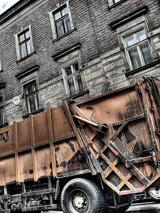

In [26]:
import PIL
il[0]

In [18]:
splitter = partial(grandparent_splitter, valid_name='val')

In [20]:
train,valid = split_by_func(il, splitter)

In [27]:
#export
class SplitData():
    def __init__(self, train, valid): self.train,self.valid = train,valid
        
    def __getattr__(self,k): return getattr(self.train,k)
    #This is needed if we want to pickle SplitData and be able to load it back without recursion errors
    def __setstate__(self,data:Any): self.__dict__.update(data) 
    
    @classmethod
    def split_by_func(cls, il, f):
        lists = map(il.new, split_by_func(il.items, f))
#         print(list(lists))
        return cls(*lists)

    def __repr__(self): return f'{self.__class__.__name__}\nTrain: {self.train}\nValid: {self.valid}\n'

In [28]:
t, v= split_by_func(il.items, splitter)

In [38]:
t2=il.new(v)

In [161]:
list(map(len, [t,v]))

[12894, 500]

In [40]:
sd = SplitData.split_by_func(il, splitter); sd

SplitData
Train: ImageList (12894 items)
[PosixPath('/data/home/h216520/Desktop/fastai_work/data/imagenette-160/train/n03417042/n03417042_8119.JPEG'), PosixPath('/data/home/h216520/Desktop/fastai_work/data/imagenette-160/train/n03417042/n03417042_10802.JPEG'), PosixPath('/data/home/h216520/Desktop/fastai_work/data/imagenette-160/train/n03417042/n03417042_3165.JPEG'), PosixPath('/data/home/h216520/Desktop/fastai_work/data/imagenette-160/train/n03417042/n03417042_5813.JPEG'), PosixPath('/data/home/h216520/Desktop/fastai_work/data/imagenette-160/train/n03417042/n03417042_2035.JPEG'), PosixPath('/data/home/h216520/Desktop/fastai_work/data/imagenette-160/train/n03417042/n03417042_5180.JPEG'), PosixPath('/data/home/h216520/Desktop/fastai_work/data/imagenette-160/train/n03417042/n03417042_5458.JPEG'), PosixPath('/data/home/h216520/Desktop/fastai_work/data/imagenette-160/train/n03417042/n03417042_15198.JPEG'), PosixPath('/data/home/h216520/Desktop/fastai_work/data/imagenette-160/train/n0341704

### Labeling

In [41]:
#export
from collections import OrderedDict

def uniqueify(x, sort=False):
    res = list(OrderedDict.fromkeys(x).keys())
    if sort: res.sort()
    return res

#export
class Processor(): 
    def process(self, items): return items

class CategoryProcessor(Processor):
    def __init__(self): self.vocab=None
    
    def __call__(self, items):
        #The vocab is defined on the first use.
        if self.vocab is None:
            self.vocab = uniqueify(items)
            self.otoi  = {v:k for k,v in enumerate(self.vocab)}
        return [self.proc1(o) for o in items]
    def proc1(self, item):  return self.otoi[item]
    
    def deprocess(self, idxs):
        assert self.vocab is not None
        return [self.deproc1(idx) for idx in idxs]
    def deproc1(self, idx): return self.vocab[idx]

#export
def parent_labeler(fn): return fn.parent.name

def _label_by_func(ds, f, cls=ItemList): return cls([f(o) for o in ds.items], path=ds.path)

#This is a slightly different from what was seen during the lesson,
#   we'll discuss the changes in lesson 11
class LabeledData():
    def process(self, il, proc): return il.new(compose(il.items, proc))

    def __init__(self, x, y, proc_x=None, proc_y=None):
        self.x,self.y = self.process(x, proc_x),self.process(y, proc_y)
        self.proc_x,self.proc_y = proc_x,proc_y
        
    def __repr__(self): return f'{self.__class__.__name__}\nx: {self.x}\ny: {self.y}\n'
    def __getitem__(self,idx): return self.x[idx],self.y[idx]
    def __len__(self): return len(self.x)
    
    def x_obj(self, idx): return self.obj(self.x, idx, self.proc_x)
    def y_obj(self, idx): return self.obj(self.y, idx, self.proc_y)
    
    def obj(self, items, idx, procs):
        isint = isinstance(idx, int) or (isinstance(idx,torch.LongTensor) and not idx.ndim)
        item = items[idx]
        for proc in reversed(listify(procs)):
            item = proc.deproc1(item) if isint else proc.deprocess(item)
        return item

    @classmethod
    def label_by_func(cls, il, f, proc_x=None, proc_y=None):
        return cls(il, _label_by_func(il, f), proc_x=proc_x, proc_y=proc_y)

def label_by_func(sd, f, proc_x=None, proc_y=None):
    train = LabeledData.label_by_func(sd.train, f, proc_x=proc_x, proc_y=proc_y)
    valid = LabeledData.label_by_func(sd.valid, f, proc_x=proc_x, proc_y=proc_y)
    return SplitData(train,valid)

In [42]:
ll = label_by_func(sd, parent_labeler, proc_y=CategoryProcessor())

In [43]:
assert ll.train.proc_y is ll.valid.proc_y

In [47]:
type(ll)

__main__.SplitData

In [51]:
import PIL

In [57]:
ll.train.y_obj(0)

'n03417042'

In [58]:
ll.train.proc_y.otoi

{'n03417042': 0,
 'n02102040': 1,
 'n03425413': 2,
 'n03028079': 3,
 'n01440764': 4,
 'n03394916': 5,
 'n02979186': 6,
 'n03000684': 7,
 'n03888257': 8,
 'n03445777': 9}

In [67]:
ll.train.y[3981]

3

In [68]:
ll.train[3981]

(<PIL.Image.Image image mode=RGB size=202x160 at 0x7FF21762D518>, 3)

### Transform to tensor

In [48]:
#export
class ResizeFixed(Transform):
    _order=10
    def __init__(self,size):
        if isinstance(size,int): size=(size,size)
        self.size = size
        
    def __call__(self, item): return item.resize(self.size, PIL.Image.BILINEAR)

def to_byte_tensor(item):
    res = torch.ByteTensor(torch.ByteStorage.from_buffer(item.tobytes()))
    w,h = item.size
    return res.view(h,w,-1).permute(2,0,1)
to_byte_tensor._order=20

def to_float_tensor(item): return item.float().div_(255.)
to_float_tensor._order=30

In [49]:
tfms = [make_rgb, ResizeFixed(128), to_byte_tensor, to_float_tensor]

il = ImageList.from_files(path, tfms=tfms)
sd = SplitData.split_by_func(il, splitter)
ll = label_by_func(sd, parent_labeler, proc_y=CategoryProcessor())

### Databunch

In [52]:
bs=64
train_dl,valid_dl = get_dls(ll.train,ll.valid,bs, num_workers=4)
#export
class DataBunch():
    def __init__(self, train_dl, valid_dl, c_in=None, c_out=None):
        self.train_dl,self.valid_dl,self.c_in,self.c_out = train_dl,valid_dl,c_in,c_out

    @property
    def train_ds(self): return self.train_dl.dataset

    @property
    def valid_ds(self): return self.valid_dl.dataset

In [53]:
#export
def databunchify(sd, bs, c_in=None, c_out=None, **kwargs):
    dls = get_dls(sd.train, sd.valid, bs, **kwargs)
    return DataBunch(*dls, c_in=c_in, c_out=c_out)

SplitData.to_databunch = databunchify

In [54]:
path = datasets.untar_data(datasets.URLs.IMAGENETTE_160)
tfms = [make_rgb, ResizeFixed(128), to_byte_tensor, to_float_tensor]

il = ImageList.from_files(path, tfms=tfms)
sd = SplitData.split_by_func(il, partial(grandparent_splitter, valid_name='val'))
ll = label_by_func(sd, parent_labeler, proc_y=CategoryProcessor())
data = ll.to_databunch(bs, c_in=3, c_out=10, num_workers=4)

### Model

In [58]:
cbfs = [partial(AvgStatsCallback,accuracy),
        CudaCallback]

In [59]:
#export
def normalize_chan(x, mean, std):
    return (x-mean[...,None,None]) / std[...,None,None]

_m = tensor([0.47, 0.48, 0.45])
_s = tensor([0.29, 0.28, 0.30])
norm_imagenette = partial(normalize_chan, mean=_m.cuda(), std=_s.cuda())

In [60]:
cbfs.append(partial(BatchTransformXCallback, norm_imagenette))

In [61]:
nfs = [64,64,128,256]

#export
import math
def prev_pow_2(x): return 2**math.floor(math.log2(x))

def get_cnn_layers(data, nfs, layer, **kwargs):
    def f(ni, nf, stride=2): return layer(ni, nf, 3, stride=stride, **kwargs)
    l1 = data.c_in
    l2 = prev_pow_2(l1*3*3)
    layers =  [f(l1  , l2  , stride=1),
               f(l2  , l2*2, stride=2),
               f(l2*2, l2*4, stride=2)]
    nfs = [l2*4] + nfs
    layers += [f(nfs[i], nfs[i+1]) for i in range(len(nfs)-1)]
    layers += [nn.AdaptiveAvgPool2d(1), Lambda(flatten), 
               nn.Linear(nfs[-1], data.c_out)]
    return layers

def get_cnn_model(data, nfs, layer, **kwargs):
    return nn.Sequential(*get_cnn_layers(data, nfs, layer, **kwargs))

def get_learn_run(nfs, data, lr, layer, cbs=None, opt_func=None, **kwargs):
    model = get_cnn_model(data, nfs, layer, **kwargs)
    init_cnn(model)
    return get_runner(model, data, lr=lr, cbs=cbs, opt_func=opt_func)

In [62]:
sched = combine_scheds([0.3,0.7], cos_1cycle_anneal(0.1,0.3,0.05))

In [63]:
learn,run = get_learn_run(nfs, data, 0.2, conv_layer, cbs=cbfs+[
    partial(ParamScheduler, 'lr', sched)
])

In [64]:
%time run.fit(5, learn)

train: [1.8030621679657204, tensor(0.3730, device='cuda:0')]
valid: [1.792403564453125, tensor(0.4060, device='cuda:0')]
train: [1.34838333236389, tensor(0.5508, device='cuda:0')]
valid: [1.369734619140625, tensor(0.5300, device='cuda:0')]
train: [1.0046060667752443, tensor(0.6754, device='cuda:0')]
valid: [0.9614146728515625, tensor(0.6900, device='cuda:0')]
train: [0.7327852647064527, tensor(0.7676, device='cuda:0')]
valid: [0.871258056640625, tensor(0.7160, device='cuda:0')]
train: [0.5100594874554056, tensor(0.8471, device='cuda:0')]
valid: [0.8512341918945312, tensor(0.7300, device='cuda:0')]
CPU times: user 12.8 s, sys: 6.01 s, total: 18.8 s
Wall time: 1min 45s


In [ ]:
model_summary(run, learn, data)

In [65]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): GeneralRelu()
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): GeneralRelu()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): GeneralRelu()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (3): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): GeneralRelu()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (4): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=Fa

In [79]:
def shape(h, m, inp, oup):
    print(m, '\n', m.p.shape)

In [80]:
with Hooks(learn.model.children(), shape) as h:
    _ = learn.model(run.xb)

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (1): GeneralRelu()
  (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
) 
 torch.Size([116, 16, 128, 128])
Sequential(
  (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (1): GeneralRelu()
  (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
) 
 torch.Size([116, 32, 64, 64])
Sequential(
  (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (1): GeneralRelu()
  (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
) 
 torch.Size([116, 64, 32, 32])
Sequential(
  (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (1): GeneralRelu()
  (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
) 
 torch.Size([116, 64, 16, 16])
Sequential(
  (0): Conv2d(64, 64, kernel_si

In [ ]:
#export
def model_summary(run, learn, data, find_all=False):
    xb,yb = get_batch(data.valid_dl, run)
    device = next(learn.model.parameters()).device#Model may not be on the GPU yet
    xb,yb = xb.to(device),yb.to(device)
    mods = find_modules(learn.model, is_lin_layer) if find_all else learn.model.children()
    f = lambda hook,mod,inp,out: print(f"{mod}\n{out.shape}\n")
    with Hooks(mods, f) as hooks: learn.model(xb)

## Optimizers

In [5]:
#export
from exp.nb_08 import *

In [6]:
path = datasets.untar_data(datasets.URLs.IMAGENETTE_160)

tfms = [make_rgb, ResizeFixed(128), to_byte_tensor, to_float_tensor]
bs=128

il = ImageList.from_files(path, tfms=tfms)
sd = SplitData.split_by_func(il, partial(grandparent_splitter, valid_name='val'))
ll = label_by_func(sd, parent_labeler, proc_y=CategoryProcessor())
data = ll.to_databunch(bs, c_in=3, c_out=10, num_workers=4)

In [7]:
nfs = [32,64,128,256]

cbfs = [partial(AvgStatsCallback,accuracy), CudaCallback,
        partial(BatchTransformXCallback, norm_imagenette)]

In [8]:
learn,run = get_learn_run(nfs, data, 0.4, conv_layer, cbs=cbfs)

In [9]:
run.fit(1, learn)

train: [1.7422794456239337, tensor(0.3948, device='cuda:0')]
valid: [1.42234912109375, tensor(0.5140, device='cuda:0')]


In [2]:
def get_defaults(d): return getattr(d,'_defaults',{})

In [21]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): GeneralRelu()
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): GeneralRelu()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): GeneralRelu()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (3): Sequential(
    (0): Conv2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): GeneralRelu()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=Fa

In [20]:
for i, j in list(learn.model.named_parameters()):
    print(i, j.shape)

0.0.weight torch.Size([16, 3, 3, 3])
0.2.weight torch.Size([16])
0.2.bias torch.Size([16])
1.0.weight torch.Size([32, 16, 3, 3])
1.2.weight torch.Size([32])
1.2.bias torch.Size([32])
2.0.weight torch.Size([64, 32, 3, 3])
2.2.weight torch.Size([64])
2.2.bias torch.Size([64])
3.0.weight torch.Size([32, 64, 3, 3])
3.2.weight torch.Size([32])
3.2.bias torch.Size([32])
4.0.weight torch.Size([64, 32, 3, 3])
4.2.weight torch.Size([64])
4.2.bias torch.Size([64])
5.0.weight torch.Size([128, 64, 3, 3])
5.2.weight torch.Size([128])
5.2.bias torch.Size([128])
6.0.weight torch.Size([256, 128, 3, 3])
6.2.weight torch.Size([256])
6.2.bias torch.Size([256])
9.weight torch.Size([10, 256])
9.bias torch.Size([10])


In [22]:
class Optimizer():
    def __init__(self, params, steppers, **defaults):
        # might be a generator
        self.param_groups = list(params)
        # ensure params is a list of lists
        if not isinstance(self.param_groups[0], list): self.param_groups = [self.param_groups]
        self.hypers = [{**defaults} for p in self.param_groups]
        self.steppers = listify(steppers)

    def grad_params(self):
        return [(p,hyper) for pg,hyper in zip(self.param_groups,self.hypers)
            for p in pg if p.grad is not None]

    def zero_grad(self):
        for p,hyper in self.grad_params():
            p.grad.detach_()
            p.grad.zero_()

    def step(self):
        for p,hyper in self.grad_params(): compose(p, self.steppers, **hyper)
            
#export
def sgd_step(p, lr, **kwargs):
    p.data.add_(-lr, p.grad.data)
    return p

opt_func = partial(Optimizer, steppers=[sgd_step])

#export
class Recorder(Callback):
    def begin_fit(self): self.lrs,self.losses = [],[]

    def after_batch(self):
        if not self.in_train: return
        self.lrs.append(self.opt.hypers[-1]['lr'])
        self.losses.append(self.loss.detach().cpu())        

    def plot_lr  (self): plt.plot(self.lrs)
    def plot_loss(self): plt.plot(self.losses)
        
    def plot(self, skip_last=0):
        losses = [o.item() for o in self.losses]
        n = len(losses)-skip_last
        plt.xscale('log')
        plt.plot(self.lrs[:n], losses[:n])

class ParamScheduler(Callback):
    _order=1
    def __init__(self, pname, sched_funcs):
        self.pname,self.sched_funcs = pname,listify(sched_funcs)

    def begin_batch(self): 
        if not self.in_train: return
        fs = self.sched_funcs
        if len(fs)==1: fs = fs*len(self.opt.param_groups)
        pos = self.n_epochs/self.epochs
        for f,h in zip(fs,self.opt.hypers): h[self.pname] = f(pos)
            
class LR_Find(Callback):
    _order=1
    def __init__(self, max_iter=100, min_lr=1e-6, max_lr=10):
        self.max_iter,self.min_lr,self.max_lr = max_iter,min_lr,max_lr
        self.best_loss = 1e9
        
    def begin_batch(self): 
        if not self.in_train: return
        pos = self.n_iter/self.max_iter
        lr = self.min_lr * (self.max_lr/self.min_lr) ** pos
        for pg in self.opt.hypers: pg['lr'] = lr
            
    def after_step(self):
        if self.n_iter>=self.max_iter or self.loss>self.best_loss*10:
            raise CancelTrainException()
        if self.loss < self.best_loss: self.best_loss = self.loss
            
sched = combine_scheds([0.3, 0.7], [sched_cos(0.3, 0.6), sched_cos(0.6, 0.2)]) 

cbfs = [partial(AvgStatsCallback,accuracy),
        CudaCallback, Recorder,
        partial(ParamScheduler, 'lr', sched)]

In [23]:
learn,run = get_learn_run(nfs, data, 0.4, conv_layer, cbs=cbfs, opt_func=opt_func)
%time run.fit(1, learn)

train: [1.7361109091437879, tensor(0.3986, device='cuda:0')]
valid: [1.42305908203125, tensor(0.5500, device='cuda:0')]
CPU times: user 2.68 s, sys: 1.69 s, total: 4.37 s
Wall time: 5.8 s


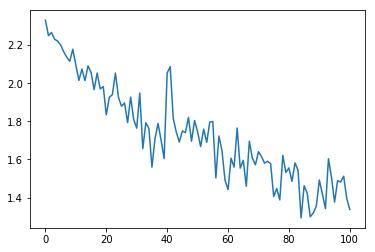

In [24]:
run.recorder.plot_loss()

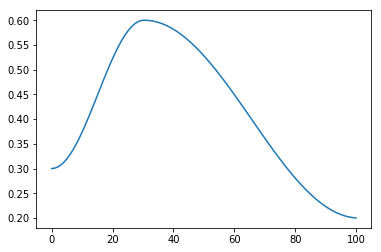

In [25]:
run.recorder.plot_lr()

In [26]:
#export
def weight_decay(p, lr, wd, **kwargs):
    p.data.mul_(1 - lr*wd)
    return p
weight_decay._defaults = dict(wd=0.)

#export
def l2_reg(p, lr, wd, **kwargs):
    p.grad.data.add_(wd, p.data)
    return p
l2_reg._defaults = dict(wd=0.)

#export
def maybe_update(os, dest, f):
    for o in os:
        for k,v in f(o).items():
            if k not in dest: dest[k] = v

def get_defaults(d): return getattr(d,'_defaults',{})

In [33]:
#export
class Optimizer():
    def __init__(self, params, steppers, **defaults):
        self.steppers = listify(steppers)
        maybe_update(self.steppers, defaults, get_defaults)
        # might be a generator
        self.param_groups = list(params)
        # ensure params is a list of lists
        if not isinstance(self.param_groups[0], list): self.param_groups = [self.param_groups]
        self.hypers = [{**defaults} for p in self.param_groups]

    def grad_params(self):
        return [(p,hyper) for pg,hyper in zip(self.param_groups,self.hypers)
            for p in pg if p.grad is not None]

    def zero_grad(self):
        for p,hyper in self.grad_params():
            p.grad.detach_()
            p.grad.zero_()

    def step(self):
        for p,hyper in self.grad_params(): compose(p, self.steppers, **hyper)

In [34]:
#export 
sgd_opt = partial(Optimizer, steppers=[weight_decay, sgd_step])

In [35]:
learn,run = get_learn_run(nfs, data, 0.4, conv_layer, cbs=cbfs, opt_func=sgd_opt)

In [37]:
model = learn.model

In [38]:
opt = sgd_opt(model.parameters(), lr=0.1)
test_eq(opt.hypers[0]['wd'], 0.)
test_eq(opt.hypers[0]['lr'], 0.1)

In [39]:
cbfs = [partial(AvgStatsCallback,accuracy), CudaCallback]

learn,run = get_learn_run(nfs, data, 0.3, conv_layer, cbs=cbfs, opt_func=partial(sgd_opt, wd=0.01))

run.fit(1, learn)

train: [1.8190761570304017, tensor(0.3680, device='cuda:0')]
valid: [1.7907322998046875, tensor(0.3600, device='cuda:0')]


### With momentum

In [ ]:
#export
class StatefulOptimizer(Optimizer):
    def __init__(self, params, steppers, stats=None, **defaults): 
        self.stats = listify(stats)
        maybe_update(self.stats, defaults, get_defaults)
        super().__init__(params, steppers, **defaults)
        self.state = {}
        
    def step(self):
        for p,hyper in self.grad_params():
            if p not in self.state:
                #Create a state for p and call all the statistics to initialize it.
                self.state[p] = {}
                maybe_update(self.stats, self.state[p], lambda o: o.init_state(p))
            state = self.state[p]
            for stat in self.stats: state = stat.update(p, state, **hyper)
            compose(p, self.steppers, **state, **hyper)
            self.state[p] = state

In [40]:
#export
class Stat():
    _defaults = {}
    def init_state(self, p): raise NotImplementedError
    def update(self, p, state, **kwargs): raise NotImplementedError    

In [41]:
class AverageGrad(Stat):
    _defaults = dict(mom=0.9)

    def init_state(self, p): return {'grad_avg': torch.zeros_like(p.grad.data)}
    def update(self, p, state, mom, **kwargs):
        state['grad_avg'].mul_(mom).add_(p.grad.data)
        return state

In [42]:
#export
def momentum_step(p, lr, grad_avg, **kwargs):
    p.data.add_(-lr, grad_avg)
    return p

In [43]:
sgd_mom_opt = partial(StatefulOptimizer, steppers=[momentum_step,weight_decay],
                  stats=AverageGrad(), wd=0.01)

learn,run = get_learn_run(nfs, data, 0.3, conv_layer, cbs=cbfs, opt_func=sgd_mom_opt)

run.fit(1, learn)

train: [1.8014285047793548, tensor(0.3848, device='cuda:0')]
valid: [1.577860107421875, tensor(0.4780, device='cuda:0')]


In [63]:
type(learn.opt.state[list(learn.opt.state.keys())[0]])

dict

In [65]:
learn.opt.steppers

[<function __main__.momentum_step(p, lr, grad_avg, **kwargs)>,
 <function __main__.weight_decay(p, lr, wd, **kwargs)>]